In [1]:
# default_exp run_sequence_3d

# Actions in video

> API details.

We use pre-trained ResNet50 model, available from [here](https://drive.google.com/drive/folders/1zvl89AgFAApbH0At-gMuZSeQB_LpNP-M)

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import os
import time
import datetime
from tqdm.notebook import tqdm
import pathlib

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

from actions_in_videos.dataset_ucf101 import UCF101, SequenceDataset, DataLoader, SequenceBatchShower
from actions_in_videos.models_resnet_3d import ResNet50_3D

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline

In [6]:
print('torch.__version__', torch.__version__)

torch.__version__ 1.4.0


In [7]:
save_dir = pathlib.Path('model-checkpoints')
save_dir.mkdir(parents=True, exist_ok=True)

pretrained_dir = pathlib.Path('model-pretrained')
pretrained_dir.mkdir(parents=True, exist_ok=True)

In [8]:
opt = {
    'num-classes': 101,
    'channels':3,
    'img-size':224,
    'sequence-length':16,
    'sample-interval': 1,
    'dataset-path': '../data/UCF101/',
    'batch-size': 32,
    'learning-rate': 0.0001,
    'num-epochs': 10,
    'checkpoint_interval': 10,
    'checkpoint-model': pretrained_dir/'resnet-50-kinetics.pth'
      }

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_shape = (opt['channels'], opt['img-size'], opt['img-size'])

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

## Create the Training set and its associated Dataloader:

In [10]:
# Define training set
train_ds = SequenceDataset(
    dataset_path=opt['dataset-path'],
    sequence_length=opt['sequence-length'],
    sample_interval=opt['sample-interval'],
    training=True,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop((224, 224)),
        transforms.Resize((opt['img-size'], opt['img-size']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)
train_dl = DataLoader(train_ds, batch_size=opt['batch-size'], shuffle=True, num_workers=4)


Number of training files: 9537


Let's make sure that we are loading the correct stuff:

fig-size:5, max_batch_len: 4, max_seq_len: 6
[['Diving'], ['PullUps'], ['IceDancing'], ['PoleVault'], ['TableTennisShot'], ['Fencing'], ['HeadMassage'], ['Diving'], ['HeadMassage'], ['BenchPress'], ['TableTennisShot'], ['WallPushups'], ['BreastStroke'], ['PlayingFlute'], ['BenchPress'], ['HammerThrow'], ['JavelinThrow'], ['CricketBowling'], ['YoYo'], ['HandstandWalking'], ['Mixing'], ['JugglingBalls'], ['Nunchucks'], ['PlayingCello'], ['Typing'], ['PlayingGuitar'], ['JumpRope'], ['Typing'], ['PullUps'], ['ApplyEyeMakeup'], ['StillRings'], ['WallPushups']]


<Figure size 720x720 with 0 Axes>

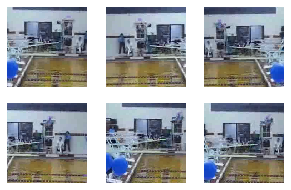

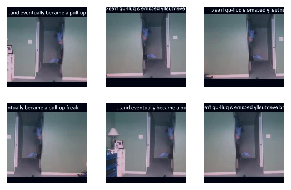

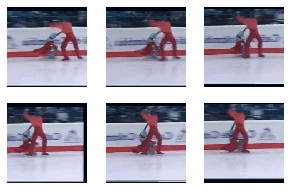

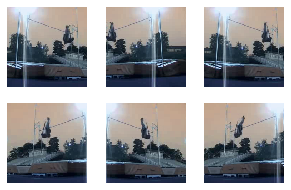

In [11]:
sb = SequenceBatchShower(train_dl, fig_size=5, max_batch_len=4, max_seq_len=6)
print(sb)

sb.showBatch(3, scale=255, permuteToImg=(0,2,3,1))

# Define test set

In [12]:
test_ds = SequenceDataset(
    dataset_path=opt['dataset-path'],
    sequence_length=opt['sequence-length'],
    sample_interval=opt['sample-interval'],
    training=False,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((opt['img-size'], opt['img-size']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)


test_dl = DataLoader(test_ds, batch_size=opt['batch-size'], shuffle=False, num_workers=4)

Number of validation files: 3783


We can see what it contains. Note that in this case, there is no randomness so most likely all frames will be from the same video.

fig-size:5, max_batch_len: 4, max_seq_len: 6
[['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['Archery'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling'], ['BabyCrawling']]


<Figure size 720x720 with 0 Axes>

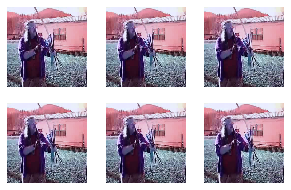

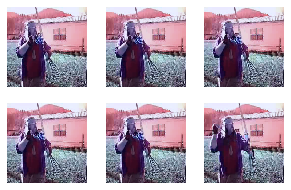

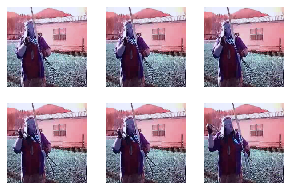

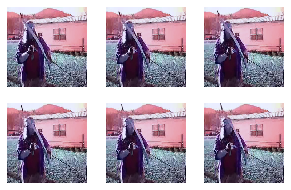

In [13]:
sb = SequenceBatchShower(test_dl, fig_size=5, max_batch_len=4, max_seq_len=6)
print(sb)

sb.showBatch(3, scale=255, permuteToImg=(0,2,3,1))

# Define the model

In [14]:
# Classification criterion
criterion = nn.CrossEntropyLoss().to(device)

# Define network
model = ResNet50_3D(num_classes=101,
                    model_pretrained=opt['checkpoint-model'],
                    sample_size=opt['img-size'], 
                    sample_duration=opt['sequence-length'])

model = model.to(device)

ResNet50_3D is loading pretrained ResNet50 from model-pretrained/resnet-50-kinetics.pth


Freeze the parameters of the parts we do not want to train and set to true those of the last few layers that we are interested in updating.

The dataset is not large enough to warrant training a full ResNet-50 model. 

To start, we will just fine-tune the output layer and the last BottleNeck block (or residual block). `model.layer4` contains three residual blocks implying model.layer4[2] is the last of these three residual blocks. Fine-tuning only the top layers also reduces the amount of GPU memory, meaning a higher batch size can be used and the model can be trained more quickly with less overfitting.

In [15]:
model

ResNet50_3D(
  (feature_extractor): ResNet(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplac

In [16]:
for param in model.parameters():
    param.requires_grad_(False)

for param in model.feature_extractor.layer4[0].parameters():
    param.requires_grad_(True)
for param in model.feature_extractor.fc.parameters():
    param.requires_grad_(True)

params = []
for param in model.feature_extractor.layer4[0].parameters():
    params.append(param)
for param in model.feature_extractor.fc.parameters():
    params.append(param)

len(params)

14

In [17]:
optimizer = torch.optim.Adam(params, lr=opt['learning-rate'])

In [18]:
# if opt['checkpoint-model']:
#     print(f"Loading checkpoint model: opt['checkpoint-model']")
#     model.load_state_dict(torch.load(opt['checkpoint-model']))

## Training

We have now everything we need to build the training loop. This is done in the next two functions, the first one is to test the model on the validation set and the second one is the actual training loop.

In [22]:
def test_model(model,epoch):
    """ Evaluate the model on the test set """
    print("")
    model.eval()
    test_metrics = {"loss": [], "acc": []}
        
    for batch_i, (X, y) in enumerate(tqdm(test_dl, 'Test', leave=False)): 
        X = X.permute(0,2,1,3,4) # I think we need the input x to be size [batch_size, c, seq_len, h, w].
                
        image_sequences = Variable(X.to(device), requires_grad=True).float()
        labels = Variable(y.to(device), requires_grad=False)
            
        labels = labels.squeeze()
        if len(labels.size()) == 0:
            labels = torch.tensor([labels]).to(device)
        
        with torch.no_grad():
            # Get sequence predictions
            preds = model(image_sequences)
                    
        # Compute metrics
        acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()
        loss = criterion(preds, labels).item()
        
        # Keep track of loss and accuracy
        test_metrics["loss"].append(loss)
        test_metrics["acc"].append(acc)
        
        # Log test performance
        sys.stdout.write(
            "\r    Testing | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | "
            % (
                batch_i,
                len(test_dl),
                np.mean(test_metrics["loss"]),
                loss,
                np.mean(test_metrics["acc"]),
                acc,                
            )
        )    
    print("")

In [23]:
def train_model(model, opt, train_dl, test_dl):

    assert 'checkpoint-model' in opt.keys(), "Specify path to checkpoint model or set it to False"
    
    for epoch in tqdm(range(opt['num-epochs']), desc='Epoch #'):
        epoch_metrics = {"loss": [], "acc": []}
        prev_time = time.time()

        #print(f"--- Epoch {epoch} ---")
        for batch_i, (X, y) in enumerate(tqdm(train_dl, 'Train', leave=False)):
            model.train()

            X = X.permute(0,2,1,3,4) # I think we need the input x to be size [batch_size, c, seq_len, h, w].
        
            if X.size(0) == 1:
                continue

            image_sequences = Variable(X.to(device), requires_grad=True).float()
            labels = Variable(y.to(device), requires_grad=False)
            
            labels = labels.squeeze()
            if len(labels.size()) == 0:
                labels = torch.tensor([labels]).to(device)

            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                # Get sequence predictions
                preds = model(image_sequences)

                # Compute metrics   
                loss = criterion(preds, labels)
                acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()

                loss.backward()
                optimizer.step()

            # Keep track of epoch metrics
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)

            # Determine approximate time left
            batches_done = epoch * len(train_dl) + batch_i
            batches_left = opt['num-epochs'] * len(train_dl) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\rEpoch %d/%d | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | ETA: %s"
                % (
                    epoch,
                    opt['num-epochs'],
                    batch_i,
                    len(train_dl),
                    np.mean(epoch_metrics["loss"]),
                    loss.item(),
                    np.mean(epoch_metrics["acc"]),                    
                    acc,
                    time_left,
                )
            )

#             Empty cache
            if torch.cuda.is_available():
                 torch.cuda.empty_cache()

        # Evaluate the model on the test set
        test_model(model, epoch)

        model.train()
        
        # Save model checkpoint
        if epoch % opt['checkpoint_interval'] == 0:
            os.makedirs('model-checkpoints', exist_ok=True)
            torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_{epoch}.pth")
            
    # Print log
    print("-------------------------------------------------------")
    sys.stdout.write(
        "\rEpoch %d/%d | Batch %d/%d | Loss: %f (%f), Acc: %.2f%% (%.2f%%) | ETA: %s"
        % (
            epoch+1,
            opt['num-epochs'],
            batch_i,
            len(train_dl),
            np.mean(epoch_metrics["loss"]),
            loss.item(),            
            np.mean(epoch_metrics["acc"]),
            acc,
            time_left,
        )
    )
    
    # save last model
    os.makedirs('model-checkpoints', exist_ok=True)
    random_int = int(np.random.uniform(0,1e14))
    torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_{epoch}_{random_int}.pth")
    print(f"Model saved as: model-checkpoints/{model.__class__.__name__}_{epoch}_{random_int}.pth")

In [24]:
train_model(model, opt, train_dl, test_dl)

Epoch 0/10 | Batch 297/299 | Loss: 1.390559 (1.095386), Acc: 77.28% (81.25%) | ETA: 2:06:24.729063


    Testing | Batch 118/119 | Loss: 2.211647 (2.981683), Acc: 47.75% (28.57%) |  


Epoch 1/10 | Batch 297/299 | Loss: 0.695110 (0.613467), Acc: 89.34% (93.75%) | ETA: 0:35:39.5797383


    Testing | Batch 118/119 | Loss: 2.080804 (3.257931), Acc: 47.06% (0.00%) |  


Epoch 2/10 | Batch 297/299 | Loss: 0.402311 (0.456842), Acc: 94.19% (90.62%) | ETA: 1:58:41.7045312


    Testing | Batch 118/119 | Loss: 2.043397 (2.929570), Acc: 48.27% (0.00%) |   


Epoch 3/10 | Batch 297/299 | Loss: 0.254326 (0.107740), Acc: 96.45% (100.00%) | ETA: 0:26:53.857521


    Testing | Batch 118/119 | Loss: 2.048209 (3.641825), Acc: 48.84% (0.00%) |  


Epoch 4/10 | Batch 297/299 | Loss: 0.187302 (0.199004), Acc: 97.16% (96.88%) | ETA: 0:22:17.6403039


    Testing | Batch 118/119 | Loss: 2.026912 (3.322984), Acc: 49.16% (0.00%) |   


Epoch 5/10 | Batch 297/299 | Loss: 0.139636 (0.253238), Acc: 98.02% (93.75%) | ETA: 1:52:32.6636730


    Testing | Batch 118/119 | Loss: 1.987361 (3.827463), Acc: 50.74% (0.00%) |  


Epoch 6/10 | Batch 297/299 | Loss: 0.108544 (0.046896), Acc: 98.50% (100.00%) | ETA: 0:13:32.956032


    Testing | Batch 118/119 | Loss: 2.083042 (3.984737), Acc: 47.87% (0.00%) |   


Epoch 7/10 | Batch 297/299 | Loss: 0.092133 (0.085255), Acc: 98.55% (100.00%) | ETA: 0:15:38.528967


    Testing | Batch 118/119 | Loss: 1.989848 (2.441302), Acc: 51.45% (57.14%) | 


Epoch 8/10 | Batch 297/299 | Loss: 0.077498 (0.052139), Acc: 98.62% (100.00%) | ETA: 0:04:31.971537


    Testing | Batch 118/119 | Loss: 2.051662 (4.130655), Acc: 49.02% (14.29%) | 


Epoch 9/10 | Batch 297/299 | Loss: 0.072024 (0.172662), Acc: 98.86% (96.88%) | ETA: 0:00:07.8759860


    Testing | Batch 118/119 | Loss: 2.109526 (2.858141), Acc: 48.07% (14.29%) |  

-------------------------------------------------------
Epoch 10/10 | Batch 298/299 | Loss: 0.072024 (0.172662), Acc: 98.86% (96.88%) | ETA: 0:00:07.875986Model saved as: model-checkpoints/ResNet50_3D_9_59557481269113.pth


In [ ]:
[batch_size,3,16,224,224].

In [ ]:
from nbdev.export import *
notebook2script()